In [10]:
import os, re, math, json, shutil, pprint
import IPython.display as display
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib
import matplotlib.pyplot as plt
import pathlib
from skimage import io
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras.callbacks import History
from sklearn.preprocessing import LabelEncoder
print(tf.__version__)

2.8.2


In [11]:
from os import listdir
from os.path import isfile, join

images = []
labels = []
dataset_path = './MLBD-dataset-IML-2022-Anglo-Saxion-Runes/'
for file_name in listdir(dataset_path):
    full_path = join(dataset_path, file_name)
    if isfile(full_path):
        if re.match(r".*\.png$", full_path):
            image_current = io.imread(full_path, as_gray=True)
            image_label = file_name.split('_')[0].lower()
            # append to the array
            images.append(image_current)
            labels.append(image_label)

Data imbalance 

In the next cell we are going to check for any imbalance in our data

In [54]:
# from collections import Counter

# counter = Counter(labels)
# for k,v in counter.items():
#     per = v / len(labels) * 100
#     print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
# plt.bar(counter.keys(), counter.values())
# plt.show()

We knew from the previous course that the dataset is quite balanced and therefore we will not perform any balancing techniques on the dataset.

We are going to split our data using the train_test_split function from sklearn. We will use 20% of the data for validation and 80% for training.

In [12]:
from sklearn.model_selection import train_test_split

# LabelEncoder().fit_transform(y)

encoded_labels = keras.utils.to_categorical(LabelEncoder().fit_transform(labels))

X_train, X_test, y_train, y_test = train_test_split(np.array(images), np.array(encoded_labels), test_size=0.2, random_state=123)

We are going to use the following utility function to plot the training and validation loss and accuracy of our models.

In [13]:
def plot_acc_loss(history):
    plt.figure(figsize=(20,8))
    
    plt.subplot(1,2,1)
    plt.ylim(-0.1, 1.1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.show()

We are going to train our models with 20 epochs of 32 batch size.

The reason of using 32 a batch size of 32 is that the dataset is small and from the sources that we have used we have found that 32 is a good batch size for small datasets. Nevertheless, the epoch are the way the models are improving and having a bigger batch size would not make a big difference unless we have a larger dataset.

Later we will create an early stopper to stop the training when our model is not improving.

source:
- https://stackoverflow.com/a/38405970
- https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e

In [63]:
EPOCHS = 20
BATCH_SIZE = 32

Basic method to define the structure of the convolutional neural network

Our structure consists of the following:

1. Input layer with the shape of the image (128, 128, 1)
2. (layers) that would be defined later
3. Flatten layer to flatten the output of the previous layers
4. Dense layer with 512 neurons and relu activation function
5. Desnse layer for our output with 11 neurons (which represents the runes) and softmax activation function

As you can observe, we use the adam optimizer (with default learning rate of 0.001) and the categorical crossentropy loss function and using the metrics for the accuracy.

source: 
- https://blog.slavv.com/37-reasons-why-your-neural-network-is-not-working-4020854bd607

In [1]:
def create_model(layers=[], kernel_size =(3, 3), debug=False):
    model = tf.keras.models.Sequential()
    # Define the input layer 1 channel
    model.add(tf.keras.layers.Input(shape=(128, 128, 1))) 
    
    # Adding convolutional layers
    for layer in layers:
        model.add(layer)

    # Flatten the output from the convolutional layers
    model.add(tf.keras.layers.Flatten())

    # Define the fully connected layer
    model.add(tf.keras.layers.Dense(64, activation='relu'))

    # Output layer with 11 neurons as we have 11 runes to classify
    # which is using the softmax activation function
    model.add(tf.keras.layers.Dense(11, activation='softmax'))

    if (debug):
        model.summary()
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

We're also using the early stopping callback to stop the training if the loss is not decreasing for 3 epochs.

source:
- https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
- https://pub.towardsai.net/keras-earlystopping-callback-to-train-the-neural-networks-perfectly-2a3f865148f7

In [65]:
def early_stopping():
    return tf.keras.callbacks.EarlyStopping(monitor='accuracy', baseline=95, patience=3, verbose=1)

In our experiments we are going to use a kernel size of (3,3) for all convolutional layers as we are trying to find local patterns in our runes and preserv the information in the image.
- source: https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363

In [56]:
kernel_size = (3, 3)

At the same time we would use the Conv2D layer with a certain number fo neurons (64 in this example which would change for some experiments), kernel size of (3,3), which has been defined above and relu activation function.
We are adding the padding same as we would like to capture as much information as possible from the image, even in the corners, where the padding is helpful.

source: 
- https://www.geeksforgeeks.org/keras-conv2d-class/
- https://keras.io/api/layers/convolution_layers/convolution2d/

In [ ]:
tf.keras.layers.Conv2D(64, kernel_size, activation='relu', padding='same')

Something that we have noticed during our experiments is that the MaxPooling is boosting the training speed, quite a lot. Then we started reading about it turns out that the MaxPooling is a pooling layer that is used after a convolutional layer. It is used to reduce the spatial dimensions of the output volume of the convolutional layer. It is used to reduce the number of parameters and computation in the network, and hence to also control overfitting. It is also used to some degree to make feature detectors more invariant to their position in the input. 

Therefore, we are going to use the MaxPooling layer with a pool size of (2,2) which would reduce the size of the image by half.


Alex laptop's specifications:
- CPU: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz   2.80 GHz
- RAM: 16.0 GB
- GPU: NVIDIA T500

with this pc configuration we noticed that it takes around ~1 hour to train the model with 15 epochs of 32 batch size, without the MaxPooling layer. We attached a screenshot of the training process.

![Training](./experiment_1_no_maxpooling.png)
![Results](./experiment_1_no_maxpooling_results.png)

source:
- https://paperswithcode.com/method/max-pooling#:~:text=Max%20Pooling%20is%20a%20pooling,used%20after%20a%20convolutional%20layer.
- https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/

In [18]:
tf.keras.layers.MaxPooling2D((2, 2)),

(<keras.layers.pooling.MaxPooling2D at 0x16e05db2d90>,)

Stores the model and the history of the training

In [19]:
models_and_history = []

# Experiment 1

In the first experiment, we are going to use the following layers:
2 Conv2D layers with 32 filters and 3x3 kernel size and relu activation function

Epoch 1/15
61/61 [==============================] - 308s 5s/step - loss: 7.4814 - accuracy: 0.5302 - val_loss: 0.4395 - val_accuracy: 0.8825
Epoch 2/15
61/61 [==============================] - 236s 4s/step - loss: 0.1417 - accuracy: 0.9603 - val_loss: 0.2566 - val_accuracy: 0.9340
Epoch 3/15
61/61 [==============================] - 214s 4s/step - loss: 0.0086 - accuracy: 0.9995 - val_loss: 0.2912 - val_accuracy: 0.9361
Epoch 4/15
61/61 [==============================] - 213s 4s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2835 - val_accuracy: 0.9402
Epoch 5/15
61/61 [==============================] - 160s 3s/step - loss: 2.9966e-04 - accuracy: 1.0000 - val_loss: 0.2990 - val_accuracy: 0.9402
Epoch 6/15
61/61 [==============================] - 135s 2s/step - loss: 1.6359e-04 - accuracy: 1.0000 - val_loss: 0.3137 - val_accuracy: 0.9402
Epoch 7/15
61/61 [==============================] - 136s 2s/step - loss: 1.1231e-04 - accuracy: 1.0000 - val_loss: 0.3264 - val_accuracy: 0.9402
E

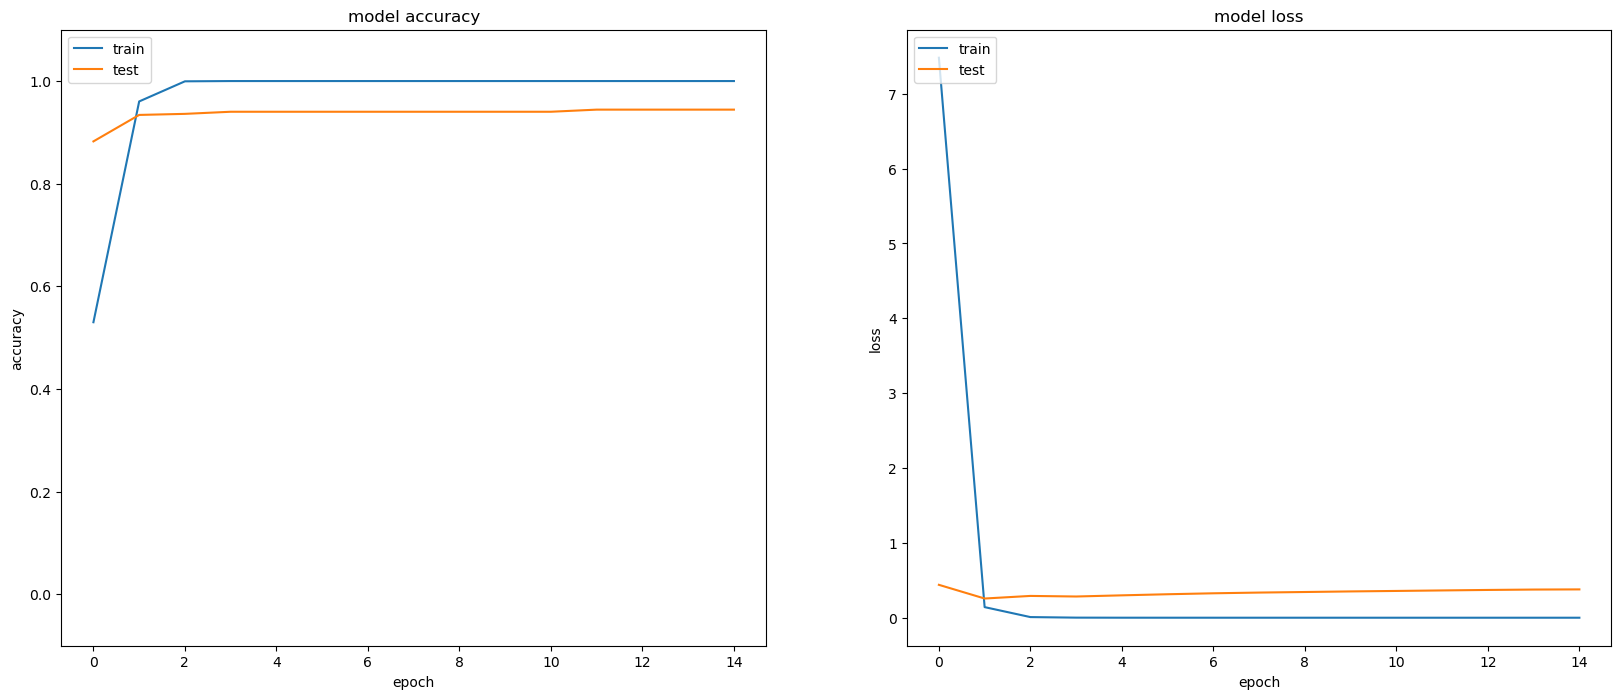

In [31]:
n_32 = [
    tf.keras.layers.Conv2D(32, kernel_size, activation='relu', padding='same'),
    
    tf.keras.layers.Conv2D(32, kernel_size, activation='relu', padding='same'),
]

model = create_model(layers=n_32)
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.2, callbacks=[early_stopping()])
evaluation_results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
plot_acc_loss(history)
models_and_history.append((model, history, evaluation_results))

Our first model looks like it's overfitting in the first epochs, but it's not the case. We can see that the validation loss is decreasing and the validation accuracy is increasing. We can also see that the training loss is decreasing and the training accuracy is increasing.
As far as we have noticed during the training our model is overffiting from the 4th epoch. We can see that the loss reached a global low and an accuracy of 1.00. But from the 5th we can see that the val_accuracy is not increasing anymore, until the 12th epoch. 

Takeaway:
As a takeaway from this experiment is that we will change the early stopping callback to stop the training if the validation accuracy is not increasing for 2 epochs.

In [38]:
def early_stopping_v2():
    return tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)

# Experiment 2

In this experiment we have increased the number of neurons to 64 to see if we can get better results. Also, we added the new early stopping callback to stop the training if the validation accuracy is not increasing for 3 epochs.

In addition to the maxpooling we added the dropout layer with a rate of 0.2. The dropout layer is a regularization technique for reducing overfitting in neural networks by preventing complex co-adaptations on training data. It is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.

Epoch 1/20
61/61 [==============================] - 37s 603ms/step - loss: 1.6030 - accuracy: 0.5508 - val_loss: 0.4488 - val_accuracy: 0.8742
Epoch 2/20
61/61 [==============================] - 37s 613ms/step - loss: 0.1758 - accuracy: 0.9515 - val_loss: 0.2017 - val_accuracy: 0.9485
Epoch 3/20
61/61 [==============================] - 37s 612ms/step - loss: 0.0405 - accuracy: 0.9907 - val_loss: 0.1559 - val_accuracy: 0.9567
Epoch 3: early stopping
19/19 [==============================] - 2s 130ms/step - loss: 0.2161 - accuracy: 0.9521


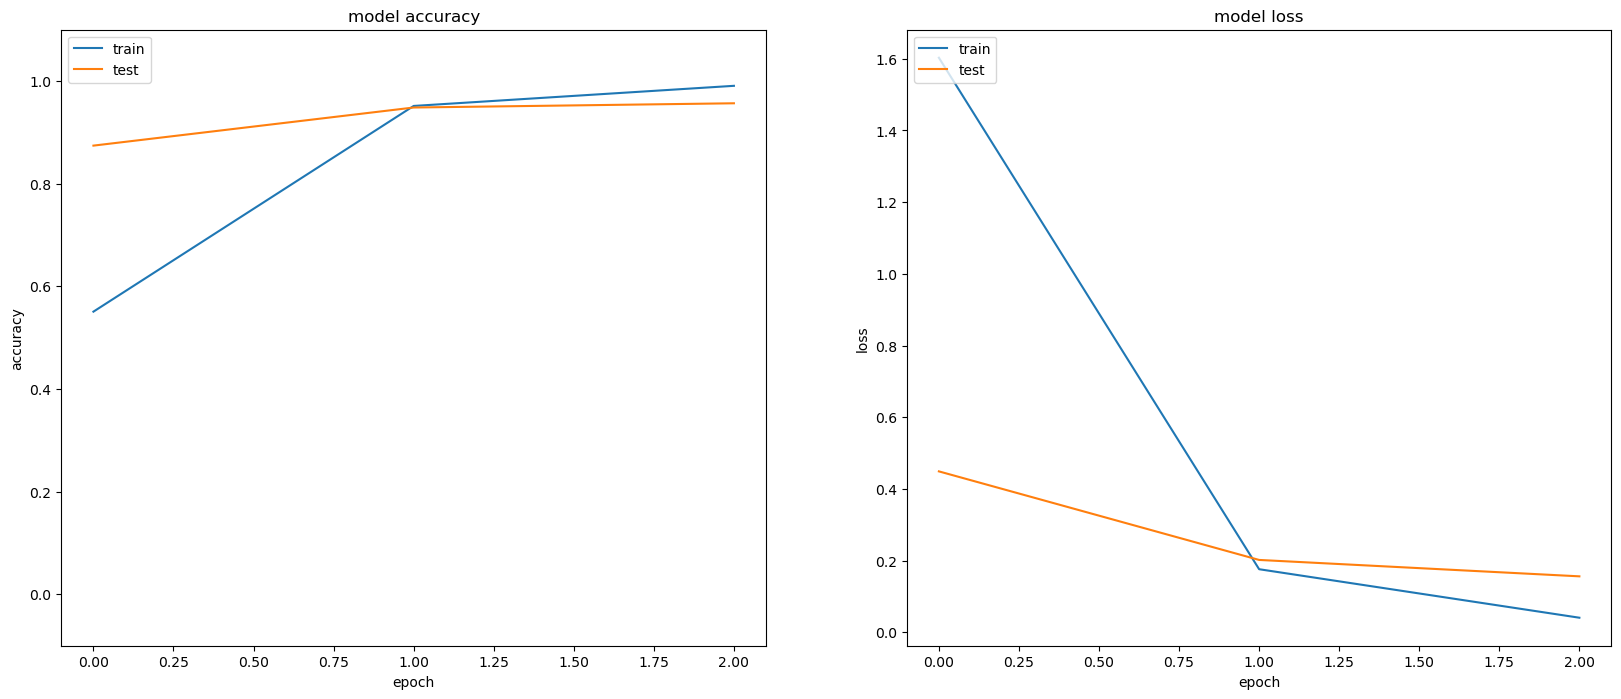

In [66]:
model = create_model(layers=[
    tf.keras.layers.Conv2D(64, kernel_size, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, kernel_size, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
])
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.2, callbacks=[early_stopping()])
evaluation_results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
plot_acc_loss(history)
models_and_history.append((model, history, evaluation_results))

Our second model looks like it's overfitting in the second epoch. In the second 

# Experiment 3

This experiment is using 4 Conv2D layers with 64, 128 and 256 filters with BatchNormalization and MaxPooling. 

The network structure is based on a kaggle notebook which is states that is the best performing structure on the MNIST dataset. (which is similar to our)

source:
- https://www.kaggle.com/code/elcaiseri/mnist-simple-cnn-keras-accuracy-0-99-top-1/notebook

In [70]:
model = create_model(layers=[
  tf.keras.layers.Conv2D(64, kernel_size, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Conv2D(filters=128, kernel_size= kernel_size, activation="relu"),
  tf.keras.layers.Conv2D(filters=128, kernel_size= kernel_size, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Conv2D(filters=256, kernel_size= kernel_size, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.BatchNormalization(),
])
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=[early_stopping()])
evaluation_results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
plot_acc_loss(history)
models_and_history.append((model, history, evaluation_results))

Epoch 1/20


# Experiment 4

For this experiment we are using the previous structure but we are going to add some dropout layers to see if we can improve the results.

source:
- https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/
- https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

Epoch 1/100
76/76 [==============================] - 159s 2s/step - loss: 1.9674 - accuracy: 0.4394 - val_loss: 49.8345 - val_accuracy: 0.0776
Epoch 2/100
76/76 [==============================] - 145s 2s/step - loss: 1.4472 - accuracy: 0.5602 - val_loss: 59.7364 - val_accuracy: 0.0776
Epoch 3/100
76/76 [==============================] - 177s 2s/step - loss: 1.0749 - accuracy: 0.6696 - val_loss: 51.8527 - val_accuracy: 0.0776
Epoch 4/100
76/76 [==============================] - 198s 3s/step - loss: 0.8394 - accuracy: 0.7533 - val_loss: 53.5773 - val_accuracy: 0.0776
Epoch 4: early stopping
76/76 [==============================] - 39s 506ms/step - loss: 53.3916 - accuracy: 0.0734


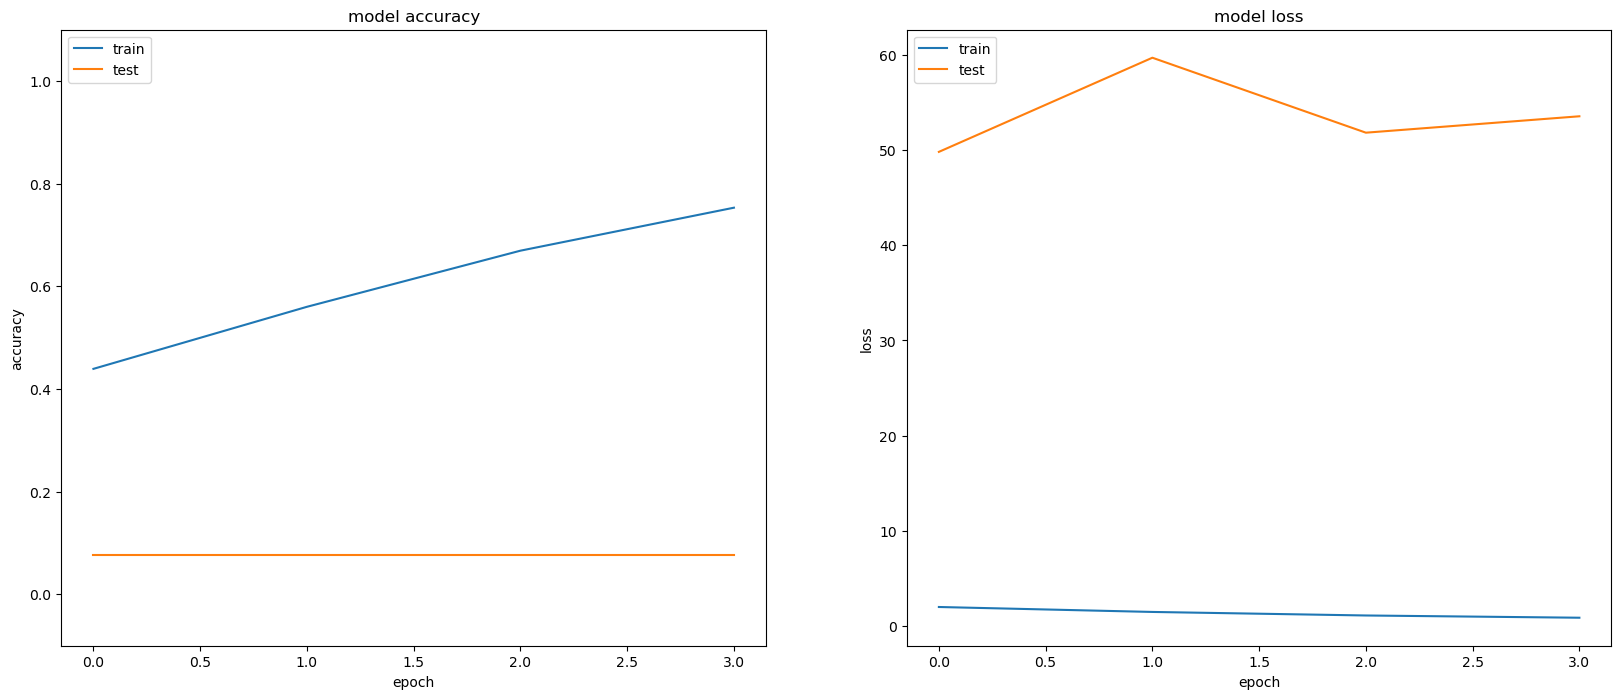

In [42]:
model = create_model(layers=[
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.Conv2D(64, kernel_size, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Conv2D(filters=128, kernel_size = kernel_size, activation="relu"),
  tf.keras.layers.Conv2D(filters=128, kernel_size= kernel_size, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Conv2D(filters=256, kernel_size= kernel_size, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.BatchNormalization(),
])
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=[early_stopping_v2()])
evaluation_results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
plot_acc_loss(history)
models_and_history.append((model, history, evaluation_results))

# Experiment 5

In our 5th experiment we added data augmentation to see if we can improve the results. As well as 3 Conv2D layers with 64 and 32 filters with BatchNormalization,  MaxPooling and Dropout. 

In [46]:
model = create_model(layers=[
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    
    tf.keras.layers.Conv2D(64, kernel_size, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, kernel_size, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(32, kernel_size, padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
])
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=[early_stopping()])
evaluation_results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
plot_acc_loss(history)
models_and_history.append((model, history, evaluation_results))

Epoch 1/100
76/76 [==============================] - 62s 789ms/step - loss: 1.6408 - accuracy: 0.4468 - val_loss: 3.1595 - val_accuracy: 0.0776
Epoch 2/100
76/76 [==============================] - 69s 908ms/step - loss: 1.0502 - accuracy: 0.6502 - val_loss: 2.7834 - val_accuracy: 0.0792
Epoch 3/100
76/76 [==============================] - 65s 862ms/step - loss: 0.8239 - accuracy: 0.7240 - val_loss: 2.2125 - val_accuracy: 0.1238
Epoch 4/100
76/76 [==============================] - 54s 713ms/step - loss: 0.6481 - accuracy: 0.7888 - val_loss: 2.2818 - val_accuracy: 0.0875
Epoch 5/100
76/76 [==============================] - 61s 800ms/step - loss: 0.5241 - accuracy: 0.8309 - val_loss: 2.0247 - val_accuracy: 0.2937
Epoch 6/100
76/76 [==============================] - 71s 937ms/step - loss: 0.4611 - accuracy: 0.8498 - val_loss: 2.7283 - val_accuracy: 0.0974
Epoch 7/100
76/76 [==============================] - 80s 1s/step - loss: 0.3897 - accuracy: 0.8767 - val_loss: 4.0996 - val_accuracy: 0.

KeyboardInterrupt: 

# Experiment 6

In our final experiment we are traing to do transfer learning with a pre-trained model that we have picked for image classification. We are using the 

source:
- https://www.philschmid.de/image-classification-huggingface-transformers-keras
- https://huggingface.co/google/vit-base-patch16-224

In [ ]:
model = create_model(layers=[
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    
    tf.keras.layers.Conv2D(64, kernel_size, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, kernel_size, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(32, kernel_size, padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
])
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=[early_stopping()])
evaluation_results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
plot_acc_loss(history)
models_and_history.append((model, history, evaluation_results))

# Conclusion

#todo